
Transfer Learning for Computer Vision Tutorial
==============================================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at `cs231n notes <https://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
%matplotlib inline
!python --version

Python 3.6.9


Extra package for face detection

In [3]:
!pip3 install torch-mtcnn

In [4]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

import tqdm
from torch_mtcnn import detect_faces
from PIL import Image
import imageio
from sklearn.model_selection import StratifiedShuffleSplit


plt.ion()   # interactive mode


Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [5]:
def recursive_glob(rootdir=".", suffix=".tif"):
    """Performs recursive glob with given suffix and rootdir 
        :param rootdir is the root directory
        :param suffix is the suffix to be searched
    """
    return [
        os.path.join(looproot,filename)
        for looproot, _, filenames in os.walk(rootdir)
        for filename in filenames
        if filename.endswith(suffix) or filename.endswith('.png') or filename.endswith('.npy')
    ]

def get_dataset_base(root):

    info_dict = {}

    list_images = recursive_glob(root, suffix='jpg')

    classes = sorted(list(set([i.split('/')[-2] for i in list_images]))) 

    labels_dict = {}
    for id, c in enumerate(classes):
        labels_dict[c] = id

    list_labels = [labels_dict[i.split('/')[-2]] for i in list_images]

    info_dict['list_images'] = list_images
    info_dict['list_labels'] = list_labels
    info_dict['labels_dict'] = labels_dict
    info_dict['classes'] = classes
    info_dict['len'] = len(list_labels)

    print(classes)

    return info_dict

In [6]:
class Mask_Dataset(object):
    def __init__(self, dataset_info, indices, transform): #, root, specific_folder, img_extension, preprocessing_method=None, crop_size=(96, 112)):
        # Get images path and labels
        self.list_images = [dataset_info['list_images'][i] for i in indices]
        self.list_labels = [dataset_info['list_labels'][i] for i in indices]
        self.len = len(self.list_images)

        self.transform = transform

    def __getitem__(self, index):
        # print(self.list_images[index])
        img = Image.open(self.list_images[index]).convert('RGB')
        # print(img.size)
        # img = imageio.imread(self.list_images[index])
        label = self.list_labels[index]

        # print(img.shape)
        # bb, _ = detect_faces(Image.fromarray(img)
        
        try:
            bb, _ = detect_faces(img)
            (top, left, bottom, right, _) = bb[0].astype("int")
            img.crop((left, top, right, bottom))
            # (startX, startY, endX, endY, _) = bb[0].astype("int")
            # img = img[startY:endY, startX:endX]
        except:
            pass

        
        if self.transform:
            img = self.transform(img)

        return img, label

    def __len__(self):
        return self.len

In [7]:
root = "/content/drive/My Drive/UFMG/6º SEMESTRE/LABORATORIO DE PROJETO II/dataset/"

dataset_info = get_dataset_base(root)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

for (train_idx, test_idx) in sss.split(np.zeros(dataset_info['len']), dataset_info['list_labels']):
    indices = {'train': train_idx, 'val': test_idx}

['with_mask', 'without_mask']


In [8]:
# Data augmentation and normalization for training
# Just normalization for validation
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: Mask_Dataset(dataset_info, indices[x],
                                  data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = dataset_info['classes']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Lets use: ", device)

Lets use:  cuda:0


Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



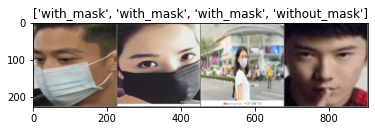

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm.tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [12]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [12]:
model_ft = models.mobilenet_v2(pretrained=True) #models.resnet18(pretrained=True)
model_ft.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=False),
                                    nn.Linear(in_features=1280, out_features=2, bias=True))
# num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [13]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.3049 Acc: 0.8984


  4%|▍         | 1/25 [04:46<1:54:41, 286.71s/it]

val Loss: 0.0804 Acc: 0.9680

Epoch 1/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.1417 Acc: 0.9564


  8%|▊         | 2/25 [05:30<1:21:58, 213.86s/it]

val Loss: 0.0177 Acc: 0.9987

Epoch 2/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.0313 Acc: 0.9910


 12%|█▏        | 3/25 [06:13<59:35, 162.54s/it]  

val Loss: 0.0110 Acc: 0.9947

Epoch 3/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.0181 Acc: 0.9957


 16%|█▌        | 4/25 [06:56<44:20, 126.67s/it]

val Loss: 0.0185 Acc: 0.9920

Epoch 4/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.0112 Acc: 0.9967


 20%|██        | 5/25 [07:39<33:53, 101.68s/it]

val Loss: 0.0038 Acc: 0.9987

Epoch 5/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.0066 Acc: 0.9993


 24%|██▍       | 6/25 [08:23<26:38, 84.16s/it] 

val Loss: 0.0035 Acc: 0.9973

Epoch 6/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.0059 Acc: 0.9990


 28%|██▊       | 7/25 [09:06<21:34, 71.92s/it]

val Loss: 0.0121 Acc: 0.9947

Epoch 7/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.0042 Acc: 0.9993


 32%|███▏      | 8/25 [09:49<17:56, 63.31s/it]

val Loss: 0.0099 Acc: 0.9960

Epoch 8/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.0033 Acc: 0.9983


 36%|███▌      | 9/25 [10:32<15:15, 57.24s/it]

val Loss: 0.0074 Acc: 0.9987

Epoch 9/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.0020 Acc: 1.0000


 40%|████      | 10/25 [11:15<13:14, 52.94s/it]

val Loss: 0.0134 Acc: 0.9973

Epoch 10/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.0013 Acc: 1.0000


 44%|████▍     | 11/25 [11:59<11:42, 50.19s/it]

val Loss: 0.0047 Acc: 0.9987

Epoch 11/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.0016 Acc: 0.9997


 48%|████▊     | 12/25 [12:42<10:24, 48.06s/it]

val Loss: 0.0039 Acc: 0.9987

Epoch 12/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.0021 Acc: 0.9993


 52%|█████▏    | 13/25 [13:25<09:19, 46.61s/it]

val Loss: 0.0058 Acc: 0.9987

Epoch 13/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.0014 Acc: 0.9997


 56%|█████▌    | 14/25 [14:08<08:20, 45.50s/it]

val Loss: 0.0031 Acc: 0.9987

Epoch 14/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.0014 Acc: 1.0000


 60%|██████    | 15/25 [14:51<07:28, 44.84s/it]

val Loss: 0.0035 Acc: 0.9987

Epoch 15/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.0021 Acc: 0.9997


 64%|██████▍   | 16/25 [15:35<06:40, 44.45s/it]

val Loss: 0.0041 Acc: 0.9973

Epoch 16/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.0014 Acc: 1.0000


 68%|██████▊   | 17/25 [16:18<05:52, 44.08s/it]

val Loss: 0.0098 Acc: 0.9987

Epoch 17/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.0014 Acc: 1.0000


 72%|███████▏  | 18/25 [17:01<05:06, 43.83s/it]

val Loss: 0.0049 Acc: 0.9987

Epoch 18/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.0012 Acc: 1.0000


 76%|███████▌  | 19/25 [17:46<04:24, 44.07s/it]

val Loss: 0.0089 Acc: 0.9973

Epoch 19/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.0011 Acc: 1.0000


 80%|████████  | 20/25 [18:30<03:39, 43.93s/it]

val Loss: 0.0141 Acc: 0.9960

Epoch 20/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.0017 Acc: 0.9997


 84%|████████▍ | 21/25 [19:14<02:55, 43.93s/it]

val Loss: 0.0064 Acc: 0.9987

Epoch 21/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.0012 Acc: 1.0000


 88%|████████▊ | 22/25 [19:59<02:12, 44.29s/it]

val Loss: 0.0130 Acc: 0.9947

Epoch 22/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.0010 Acc: 1.0000


 92%|█████████▏| 23/25 [20:42<01:28, 44.12s/it]

val Loss: 0.0075 Acc: 0.9960

Epoch 23/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.0017 Acc: 1.0000


 96%|█████████▌| 24/25 [21:26<00:43, 43.89s/it]

val Loss: 0.0077 Acc: 0.9973

Epoch 24/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.0014 Acc: 0.9997


100%|██████████| 25/25 [22:09<00:00, 53.17s/it]

val Loss: 0.0064 Acc: 0.9987

Training complete in 22m 9s
Best val Acc: 0.998668


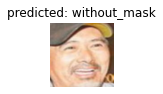

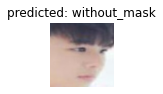

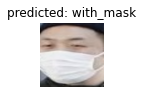

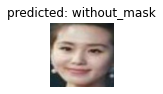

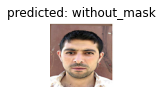

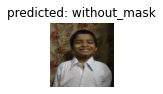

In [14]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [13]:
model_conv = models.mobilenet_v2(pretrained=True) #models.resnet18(pretrained=True)

model_conv.mean = copy.deepcopy(mean)
model_conv.std = copy.deepcopy(std)

# model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# # Parameters of newly constructed modules have requires_grad=True by default
# num_ftrs = model_conv.fc.in_features
# model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=False),
                                    nn.Linear(in_features=1280, out_features=2, bias=True))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [14]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

torch.save(model_conv, "/content/drive/My Drive/UFMG/6º SEMESTRE/LABORATORIO DE PROJETO II/best_model.pt")

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.4101 Acc: 0.8268


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
  4%|▍         | 1/25 [00:33<13:28, 33.67s/it]

val Loss: 0.1323 Acc: 0.9601

Epoch 1/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.3524 Acc: 0.8631


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
  8%|▊         | 2/25 [01:07<12:56, 33.76s/it]

val Loss: 0.0482 Acc: 0.9854

Epoch 2/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.3446 Acc: 0.8651


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 12%|█▏        | 3/25 [01:41<12:22, 33.77s/it]

val Loss: 0.0420 Acc: 0.9880

Epoch 3/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.3636 Acc: 0.8655


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 16%|█▌        | 4/25 [02:15<11:52, 33.93s/it]

val Loss: 0.0384 Acc: 0.9867

Epoch 4/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.4053 Acc: 0.8488


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 20%|██        | 5/25 [02:50<11:22, 34.13s/it]

val Loss: 0.0498 Acc: 0.9840

Epoch 5/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.3298 Acc: 0.8731


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 24%|██▍       | 6/25 [03:24<10:47, 34.09s/it]

val Loss: 0.0487 Acc: 0.9840

Epoch 6/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.3962 Acc: 0.8525


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 28%|██▊       | 7/25 [03:58<10:12, 34.05s/it]

val Loss: 0.0479 Acc: 0.9760

Epoch 7/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.2737 Acc: 0.8941


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 32%|███▏      | 8/25 [04:32<09:41, 34.18s/it]

val Loss: 0.0355 Acc: 0.9880

Epoch 8/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.2994 Acc: 0.8808


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 36%|███▌      | 9/25 [05:06<09:06, 34.16s/it]

val Loss: 0.0349 Acc: 0.9893

Epoch 9/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.2831 Acc: 0.8878


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 40%|████      | 10/25 [05:41<08:32, 34.16s/it]

val Loss: 0.0381 Acc: 0.9880

Epoch 10/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.2816 Acc: 0.8868


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 44%|████▍     | 11/25 [06:14<07:56, 34.06s/it]

val Loss: 0.0519 Acc: 0.9880

Epoch 11/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.2641 Acc: 0.8908


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 48%|████▊     | 12/25 [06:49<07:23, 34.10s/it]

val Loss: 0.0792 Acc: 0.9760

Epoch 12/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.2676 Acc: 0.8934


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 52%|█████▏    | 13/25 [07:23<06:49, 34.12s/it]

val Loss: 0.0376 Acc: 0.9867

Epoch 13/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.2704 Acc: 0.8868


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 56%|█████▌    | 14/25 [07:57<06:14, 34.09s/it]

val Loss: 0.0405 Acc: 0.9880

Epoch 14/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.2777 Acc: 0.8904


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 60%|██████    | 15/25 [08:31<05:41, 34.10s/it]

val Loss: 0.0378 Acc: 0.9867

Epoch 15/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.2942 Acc: 0.8805


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 64%|██████▍   | 16/25 [09:05<05:06, 34.10s/it]

val Loss: 0.0458 Acc: 0.9814

Epoch 16/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.2696 Acc: 0.8928


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 68%|██████▊   | 17/25 [09:39<04:33, 34.20s/it]

val Loss: 0.0407 Acc: 0.9854

Epoch 17/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.2178 Acc: 0.9118


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 72%|███████▏  | 18/25 [10:14<03:59, 34.19s/it]

val Loss: 0.0504 Acc: 0.9867

Epoch 18/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.2720 Acc: 0.8911


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 76%|███████▌  | 19/25 [10:48<03:24, 34.14s/it]

val Loss: 0.0420 Acc: 0.9854

Epoch 19/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.2925 Acc: 0.8844


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 80%|████████  | 20/25 [11:21<02:50, 34.05s/it]

val Loss: 0.0467 Acc: 0.9854

Epoch 20/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.2746 Acc: 0.8878


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 84%|████████▍ | 21/25 [11:55<02:15, 34.00s/it]

val Loss: 0.0592 Acc: 0.9800

Epoch 21/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.2507 Acc: 0.8911


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 88%|████████▊ | 22/25 [12:30<01:42, 34.09s/it]

val Loss: 0.0416 Acc: 0.9854

Epoch 22/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.2581 Acc: 0.8971


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 92%|█████████▏| 23/25 [13:03<01:07, 33.95s/it]

val Loss: 0.0395 Acc: 0.9854

Epoch 23/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.2673 Acc: 0.8918


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
 96%|█████████▌| 24/25 [13:38<00:34, 34.06s/it]

val Loss: 0.0536 Acc: 0.9880

Epoch 24/24
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.2843 Acc: 0.8831


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
100%|██████████| 25/25 [14:12<00:00, 34.09s/it]

val Loss: 0.0343 Acc: 0.9893

Training complete in 14m 12s
Best val Acc: 0.989348


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


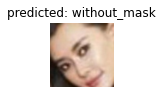

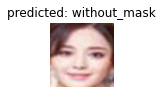

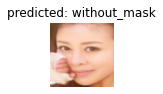

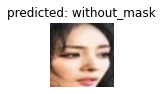

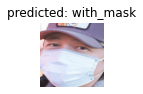

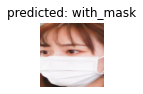

In [15]:
visualize_model(model_conv)

plt.ioff()
plt.show()

Further Learning
-----------------

If you would like to learn more about the applications of transfer learning,
checkout our `Quantized Transfer Learning for Computer Vision Tutorial <https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html>`_.



